# Time Series Transformation

In [1]:
from numpy import ndarray
from pandas import read_csv, Series, DataFrame
from matplotlib.pyplot import figure, xticks, show, subplots, savefig
from ts_functions import plot_series, HEIGHT, split_temporal_data, PREDICTION_MEASURES, plot_evaluation_results
from ds_charts import multiple_line_chart, HEIGHT, plot_overfitting_study
from sklearn.neural_network import MLPRegressor

%run p00_settings.ipynb

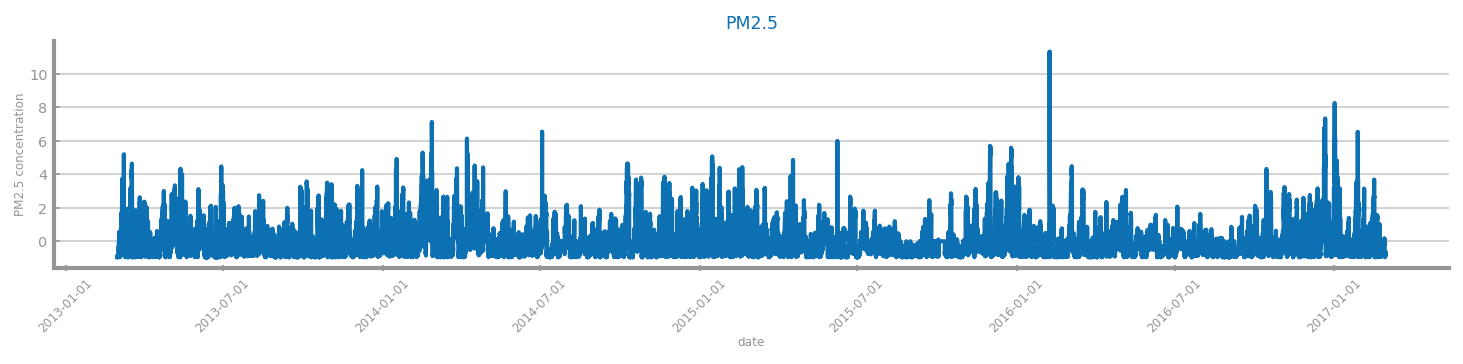

<Figure size 600x450 with 0 Axes>

In [2]:
data = read_csv(project_path + prepared_out_data_file, index_col=time_var, sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)

figure(figsize=(3*HEIGHT, HEIGHT/2))
plot_series(data[target], x_label=time_var, y_label='PM2.5 concentration', title=target)
xticks(rotation = 45)
show()
savefig(f'../03_images/ts_no_transf_study.png')

# 1 - Aggregation

In [3]:
def aggregate_by(data: Series, index_var: str, period: str):
    index = data.index.to_period(period)
    agg_df = data.copy().groupby(index).mean()
    agg_df[index_var] = index.drop_duplicates().to_timestamp()
    agg_df.set_index(index_var, drop=True, inplace=True)
    return agg_df

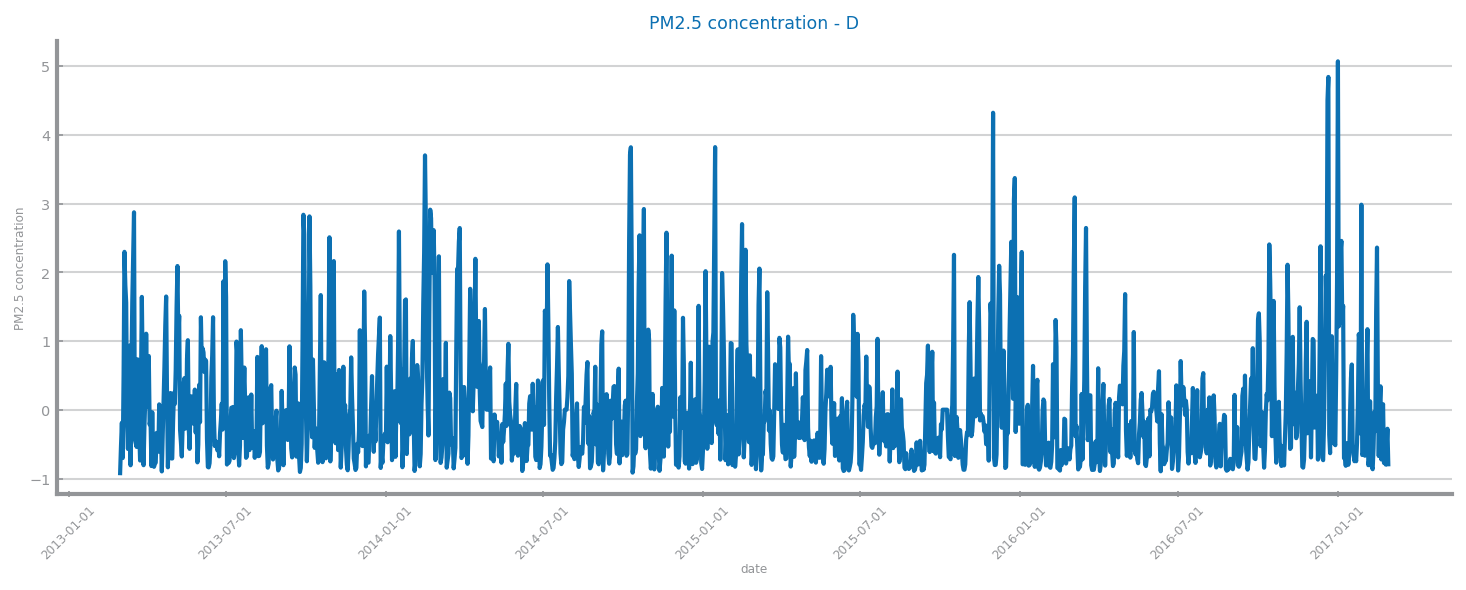

<Figure size 600x450 with 0 Axes>

In [4]:
if ts_agg:
  figure(figsize=(3*HEIGHT, HEIGHT))
  ts_transf_df = aggregate_by(data, time_var, ts_agg_period)
  plot_series(ts_transf_df[target], title=f'PM2.5 concentration - {ts_agg_period}', x_label=time_var, y_label='PM2.5 concentration')
  xticks(rotation = 45)
  show()
  savefig(f'../03_images/ts_agg_study.png')
else:
  ts_transf_df = data.copy(deep=True)

# 2 - Smoothing

In [5]:
if ts_smooth:
  WIN_SIZE = ts_smooth_size
  ts_transf_df = ts_transf_df.rolling(window=WIN_SIZE)
  ts_transf_df = ts_transf_df.mean()
  figure(figsize=(3*HEIGHT, HEIGHT/2))
  plot_series(ts_transf_df[target], title=f'PM2.5 concentration - Smoothing (win_size={WIN_SIZE})', x_label=time_var, y_label='PM2.5 concentration')
  xticks(rotation = 45)
  show()
  savefig(f'../03_images/ts_smooth_study.png')

# 3 - Differentiation

In [6]:
if ts_diff:
  ts_transf_df = ts_transf_df.diff() 
  figure(figsize=(3*HEIGHT, HEIGHT))
  plot_series(ts_transf_df[target], title='PM2.5 concentration - Differentiation', x_label=time_var, y_label='PM2.5 concentration')
  xticks(rotation = 45)
  show()
  savefig(f'../03_images/ts_diff_study.png')

# 4 - Evaluation: Multi Layer Perceptrons

Multi Layer Perceptrons are the usual representation used by neural networks for dealing with multidimensional data. In the context of prediction, in Python, they are implemented through the MLPRegressor in the sklearn.neural_network. And its use is similar for both classification and prediction.

In [7]:
eval_df = ts_transf_df.copy(deep=True)
y: ndarray = eval_df.pop(target).values
X: ndarray = eval_df.values
trnX, tstX, trnY, tstY = split_temporal_data(X, y, trn_pct=0.7)

In [8]:
lr_type = ['constant', 'invscaling', 'adaptive']
learning_rate = [.9, .6, .3, .1]
max_iter = [100, 150, 250, 500, 1000]
max_iter_warm_start = [max_iter[0]]
for el in max_iter[1:]:
    max_iter_warm_start.append(max_iter_warm_start[-1]+el)

best = ('',  0, 0.0)
last_best = 0
best_model = None

measure = 'R2'
flag_pct = True

<Figure size 600x450 with 0 Axes>

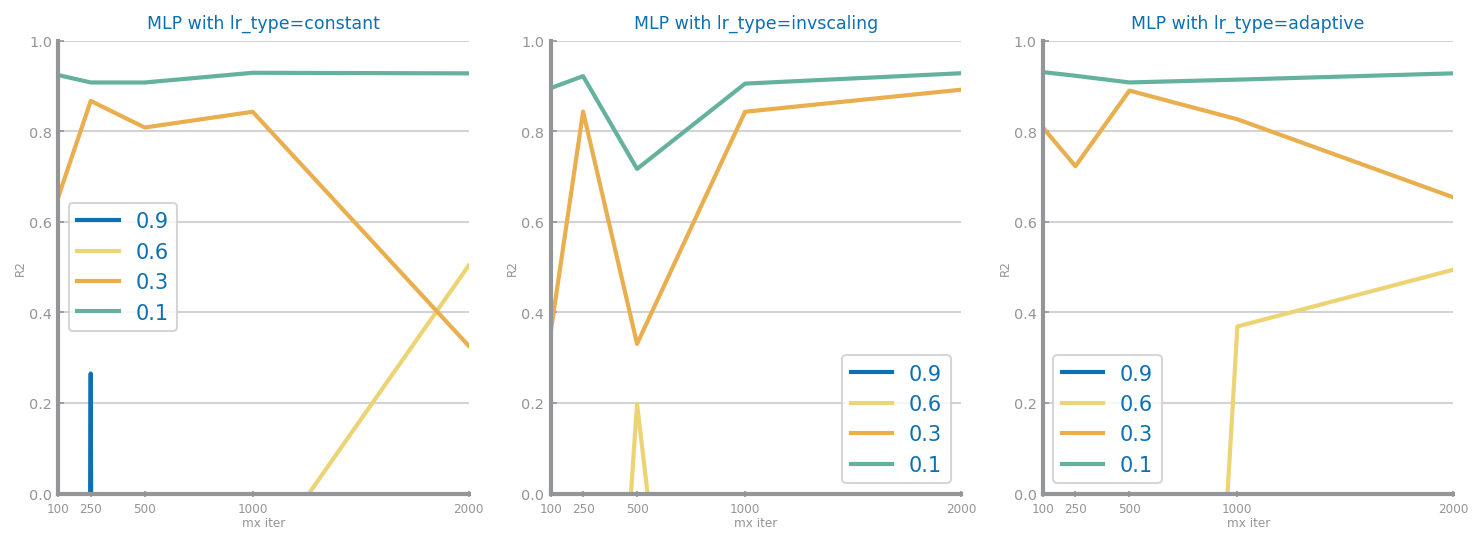

Best results with lr_type=adaptive, learning rate=0.1 and 100 max iter ==> measure=0.93


In [9]:
ncols = len(lr_type)
figure()
fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)
for k in range(len(lr_type)):
    tp = lr_type[k]
    values = {}
    warm_start = False
    for lr in learning_rate:
        yvalues = []
        for n in max_iter:
            pred = MLPRegressor(
                learning_rate=tp, learning_rate_init=lr, max_iter=n,
                activation='relu', warm_start=warm_start, verbose=False)
            pred.fit(trnX, trnY)
            prdY = pred.predict(tstX)
            yvalues.append(PREDICTION_MEASURES[measure](tstY,prdY))
            if yvalues[-1] > last_best:
                best = (tp, lr, n)
                last_best = yvalues[-1]
                best_model = pred
        values[lr] = yvalues
        warm_start = True

    multiple_line_chart(
        max_iter_warm_start, values, ax=axs[0, k], title=f'MLP with lr_type={tp}', xlabel='mx iter', ylabel=measure, percentage=flag_pct)
savefig(f'../03_images/ts_mlp_study.png')
show()
print(f'Best results with lr_type={best[0]}, learning rate={best[1]} and {best[2]} max iter ==> measure={last_best:.2f}')

After the plot you can see the parameters for which the best results were achieved. So let's see its performance, in that context in terms of other metrics.

{'RMSE': [0.1649369730993871, 0.2367455058145305], 'MAE': [0.12049019413685093, 0.1530707346018834]} {'MAPE': [1.3868876245911093, 1.6391538063965614], 'R2': [0.9610389904562525, 0.9302925877520228]}


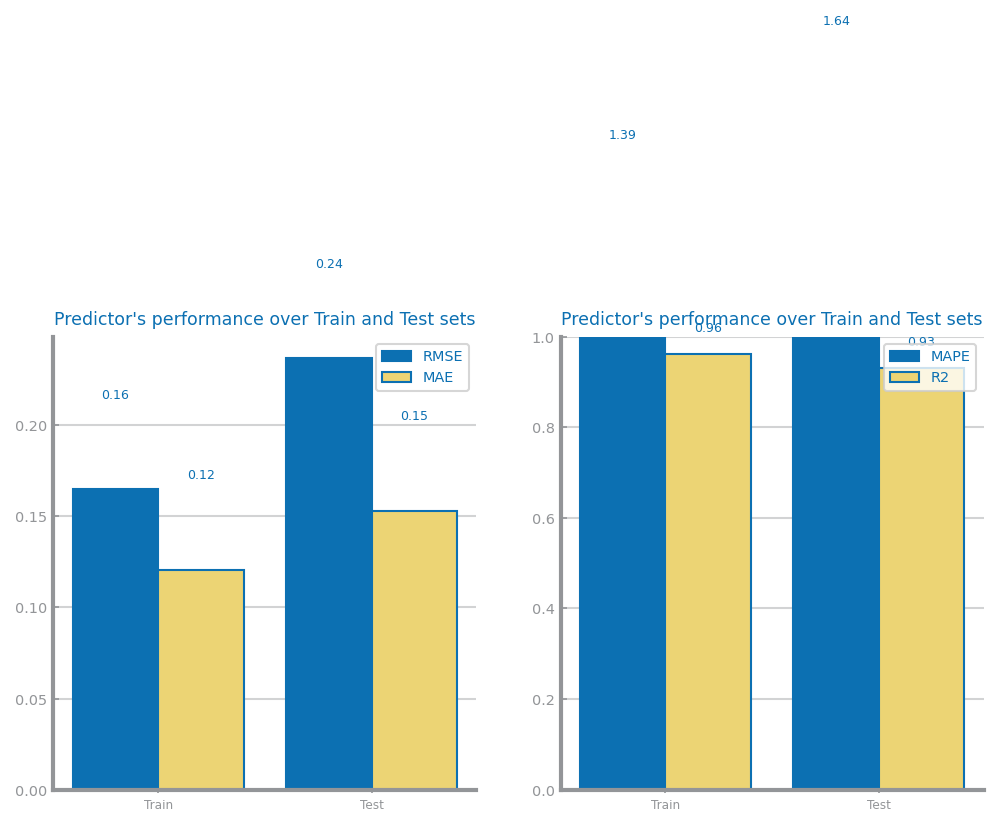

In [10]:
prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_evaluation_results(trnY, prd_trn, tstY, prd_tst, f'../03_images/ts_mlp_best.png')

Like for classification, we may visualize the performance of our predictor, studying its overfitting.

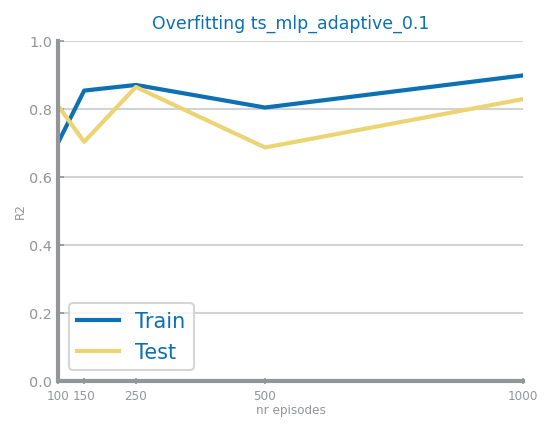

In [11]:
y_tst_values = []
y_trn_values = []
warm_start = False
for n in max_iter:
    MLPRegressor(
        learning_rate=best[0], learning_rate_init=best[1], max_iter=n, 
        activation='relu', warm_start=warm_start, verbose=False) 
    pred.fit(trnX, trnY)
    prd_tst_Y = pred.predict(tstX)
    prd_trn_Y = pred.predict(trnX)
    y_tst_values.append(PREDICTION_MEASURES[measure](tstY, prd_tst_Y))
    y_trn_values.append(PREDICTION_MEASURES[measure](trnY, prd_trn_Y))
    warm_start = True
plot_overfitting_study(max_iter, y_trn_values, y_tst_values, name=f'ts_mlp_{best[0]}_{best[1]}', xlabel='nr episodes', ylabel=measure, pct=flag_pct)

# 5 - Export DataFrame to CSV:

In [12]:
ts_transf_df.to_csv(project_path + ts_transf_data_file, index=True)